Team: X-Ray Vision
Group Members: 
- Gabriel Barrett
- Ruben Gallardo
- Zewei Liao

In [50]:
from pathlib import Path
from PIL import Image
import pandas as pd
import json
import os
from collections import namedtuple
import matplotlib.pyplot as plt
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image
import torchvision.transforms as T

# Pre-Processing & Summary Stats

In [51]:
# Getting the Path where the x-ray images are stored
current_dir = Path.cwd()

# Get the parent directory of the current file
parent_dir = current_dir.parent

# Join the parent directory with the name of the adjacent folder
data_path = parent_dir.joinpath('/chest_xray')

# Alternative Variable with data directory
alt_directory = '/Users/rubengallardo/Documents/GitHub/Spring_2024/ml_project/chest_xray'
os.listdir(alt_directory)

['.DS_Store', 'test', 'chest_xray', '__MACOSX', 'train', 'val']

In [52]:
Image_Stats = namedtuple('Image_Stats', ["split", "label", "width", "height", "pixels_sq", "ratio", "image_name", "path"])
METRICS = ["widths", "heights", "pixels_sq", "ratios"]

def compile_stats(data_path):
    tup_list = []
    sum_stats = {}
    for folder_l1 in os.listdir(data_path):     
        #iterating through test, train, and val
        if folder_l1 in ('.DS_Store', '__MACOSX'):
            continue
        fl1 = os.path.join(data_path, folder_l1)
        
        # checking if it is a folder
        if not os.path.isdir(fl1):
            continue
        sum_stats[folder_l1] = {}
        for folder_l2 in os.listdir(fl1):
            #iterating through Normal and Pnemonia
            if folder_l2 == '.DS_Store':
                continue
            fl2 = os.path.join(fl1, folder_l2)
            if not os.path.isdir(fl2):
                continue
            sum_stats[folder_l1][folder_l2] = {}

            for filename in os.listdir(fl2):
                #iterating through images
                if filename == '.DS_Store':
                    continue
                f = os.path.join(fl2, filename)
                # checking if it is a file
                if not os.path.isfile(f):
                    continue
                
                
                image_obj = Image.open(f)

                #initializing empty lists of summary statistics
                for m in METRICS:
                    sum_stats[folder_l1][folder_l2][m] = sum_stats[folder_l1][folder_l2].get(m, [])

                #fillin in the summary statistics
                sum_stats[folder_l1][folder_l2]["widths"].append(image_obj.width)
                sum_stats[folder_l1][folder_l2]["heights"].append(image_obj.height)
                
                #calculating square pixels
                square_pixels = int(image_obj.height) * int(image_obj.width)
                sum_stats[folder_l1][folder_l2]["pixels_sq"].append(square_pixels)
                
                ratio = int(image_obj.width)/int(image_obj.height)
                sum_stats[folder_l1][folder_l2]["ratios"].append(ratio)
                
                img_label = 1 if folder_l2 == 'PNEUMONIA' else 0
                
                tup = Image_Stats(folder_l1, img_label, image_obj.width, image_obj.height, square_pixels, ratio, filename, f)
                tup_list.append(tup)

                del image_obj

    return sum_stats, tup_list

In [53]:
dic, tup_list = compile_stats(alt_directory)
df = pd.DataFrame(tup_list)
df["ratio"].mean()


# Verify DataFrame
df.head(100)

,split,label,width,height,pixels_sq,ratio,image_name,path
0,test,1,1120,808,904960,1.386139,person147_bacteria_706.jpeg,/Users/rubengallardo/Documents/GitHub/Spring_2...
1,test,1,1040,696,723840,1.494253,person100_bacteria_482.jpeg,/Users/rubengallardo/Documents/GitHub/Spring_2...
2,test,1,1016,544,552704,1.867647,person78_bacteria_382.jpeg,/Users/rubengallardo/Documents/GitHub/Spring_2...
3,test,1,976,608,593408,1.605263,person124_bacteria_589.jpeg,/Users/rubengallardo/Documents/GitHub/Spring_2...
4,test,1,1168,768,897024,1.520833,person1647_virus_2848.jpeg,/Users/rubengallardo/Documents/GitHub/Spring_2...
...,...,...,...,...,...,...,...,...
95,test,1,1704,1122,1911888,1.518717,person99_bacteria_474.jpeg,/Users/rubengallardo/Documents/GitHub/Spring_2...
96,test,1,1096,880,964480,1.245455,person175_bacteria_833.jpeg,/Users/rubengallardo/Documents/GitHub/Spring_2...
97,test,1,1016,648,658368,1.567901,person144_bacteria_690.jpeg,/Users/rubengallardo/Documents/GitHub/Spring_2...
98,test,1,1336,1032,1378752,1.294574,person49_virus_101.jpeg,/Users/rubengallardo/Documents/GitHub/Spring_2...


# Image Transformations

We implemented a custom Dataset class based on [this PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files). This class will help us do our image augmentations later on. 

In [54]:
# Custom PyTorch Image Dataset Class
# Code Resource: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir_path, transform=None):
        """
        df (pandas df): pandas dataframe
        img_dir_path: directory path to your images
        transform: Compose (a PyTorch Class) that strings together several
        transform functions (e.g. data augmentation steps)
        """
        self.img_labels = df
        self.img_dir = img_dir_path
        self.transform = transform

    def __len__(self):
        """
        Returns: (int) length of your dataset
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """        
        img_path = os.path.join(self.img_labels.iloc[idx, -1])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]

        # Image Transformation
        if self.transform:
            image = self.transform(image)

        # Returns augmented and/or normalized image with label
        # Label = 1 if pneumonia and label = 0 if normal
        return image, label

In [55]:
# Augmentation for Training Data
augmentations = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),  # Horizontal flip with prob of 0.5
    T.RandomVerticalFlip(p=0.5),    # Vertical flip with prob of 0.5
    T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33)),  # Rescaling
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Shifts image horizontally or vertically by 10%
    T.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly changes brightness and contrast
    T.RandomRotation(degrees=10), # Random rotation
    T.ToTensor()  # Convert images to tensors
])

# Normalization for Validation and Test datasets
normalizations = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor() 
])

# Normalization and Augmentation Examples


For data augmentation, we conducted a literature scan of data augmentation methods used in medical image deep learning, with a focus on studies that use chest X-ray images. We identified horizontal flipping, rescaling,  shifting, rotation, brightness and contrast changes to be the most common methods that also make sense to our study. We implemented them as a starting point, keeping in mind they are hyperparameters we can revisit and readjust later depending on model performance.

### Original Sample Image

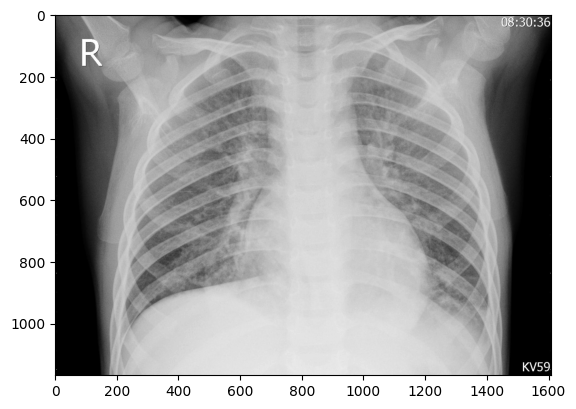

In [56]:
# Random Horizontal Flip
image = read_image(alt_directory + '/train/PNEUMONIA/person141_virus_287.jpeg')

image = image.squeeze() # Remove the channel dimension because it's grayscale
plt.imshow(image, cmap='grey')  
plt.show() 

### Random Horizonal Flip

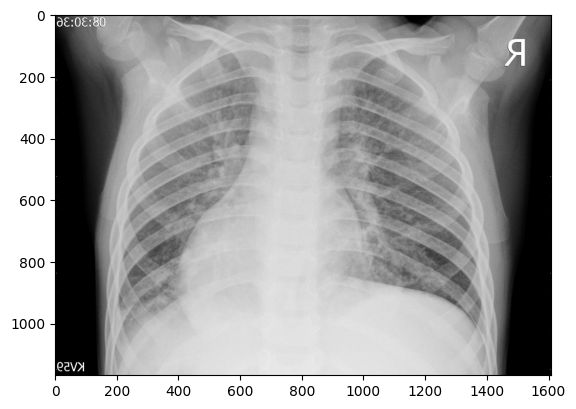

In [57]:
# Random Horizontal Flip with probability of 0.5
image = T.RandomHorizontalFlip(p=0.5)(image)

image = image.squeeze() # Remove the channel dimension because it's grayscale
plt.imshow(image, cmap='grey')  
plt.show() 

### Rescaling

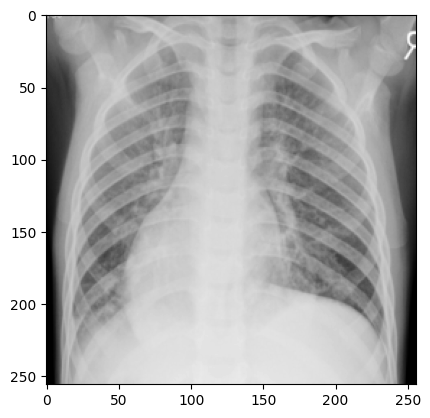

In [58]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Rescaling
image = T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33))(image)

# Remove the batch dimension for displaying
image = image.squeeze(0)

# Display the image
plt.imshow(image.squeeze(), cmap='grey')  
plt.show()

### Random Shifting

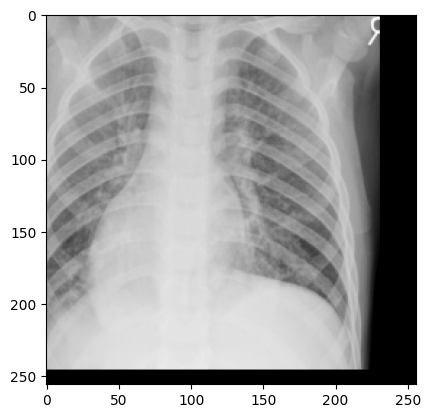

In [59]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Shifts image horizontally or vertically by 10%
image = T.RandomAffine(degrees=0, translate=(0.1, 0.1))(image)

# Remove the batch dimension for displaying
image = image.squeeze() 

plt.imshow(image, cmap='grey')  
plt.show()

### Random Changes to Brightness & Contrast

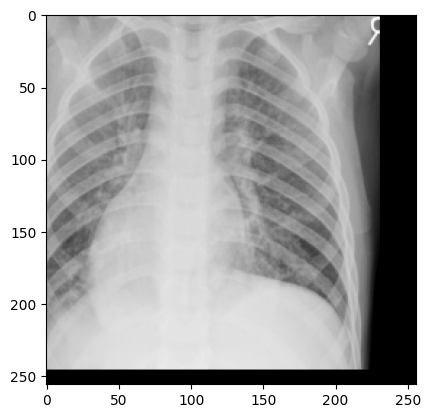

In [60]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Randomly changes brightness and contrast
T.ColorJitter(brightness=0.2, contrast=0.2)(image)

# Remove the batch dimension for displaying
image = image.squeeze()  # Now image is (C, H, W) again

plt.imshow(image, cmap='grey')  
plt.show()

### Random Rotation

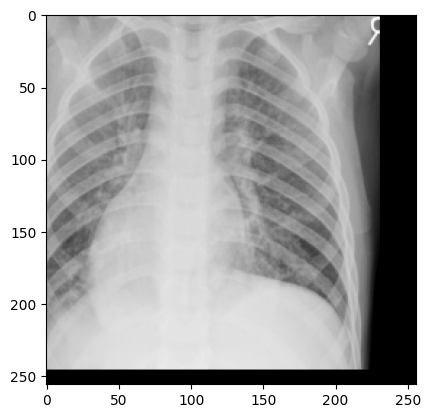

In [61]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Randomly changes brightness and contrast
T.RandomRotation(degrees=10)(image)

# Remove the batch dimension for displaying
image = image.squeeze()  # Now image is (C, H, W) again

plt.imshow(image, cmap='grey')  
plt.show()

# Create Separate DataFrames & Summary of Labels

After extracting the summary statistics of our images and storing them in a DataFrame, we prepared the data for the DataLoader by separating out the summary statistic into a training, test, and validation DataFrame. We also created a table that shows how many images fall into the normal or pneumonia group for each dataset. 

In [62]:
# Creating a separate DataFrame for each dataset
test_df = df.loc[df.loc[:, 'split'] == 'test']
train_df = df.loc[df.loc[:, 'split']=='train']
val_df = df.loc[df.loc[:, 'split'] == 'val']

# Count the occurrences of each label
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()
test_counts = test_df['label'].value_counts().sort_index()

# Prepare Data for summary table
summary_data = {
    'Normal': [train_counts.get(0, 0), val_counts.get(0, 0), test_counts.get(0, 0)],
    'Pneumonia': [train_counts.get(1, 0), val_counts.get(1, 0), test_counts.get(1, 0)]
}

# Create a summary table
summary_df = pd.DataFrame(summary_data, index=['Train', 'Validation', 'Test'])
summary_df

,Normal,Pneumonia
Train,1341,3875
Validation,8,8
Test,234,390


# Data Loader

Based on [this PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders), we passed each dataset to a DataLoader. As the documentation states, this will help us pass random mini-batches of the data to our model.

In [63]:
# Defining path for each dataset
test_dir = os.path.join(alt_directory, 'test')
train_dir = os.path.join(alt_directory, 'train')
val_dir = os.path.join(alt_directory, 'val')

# Creating a CustomImageDataset object for each dataset
training_data = CustomImageDataset(train_df, test_dir, augmentations)
val_data = CustomImageDataset(val_df, train_dir, normalizations)
test_data = CustomImageDataset(test_df, val_dir, normalizations)

# Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through Training DataLoader

To validate that our Data Loader is working, we are displaying one image from a mini-batch below with the code below. Most of the code below comes from the PyTorch documentation [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterate-through-the-dataloader).

Feature batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: torch.Size([64])


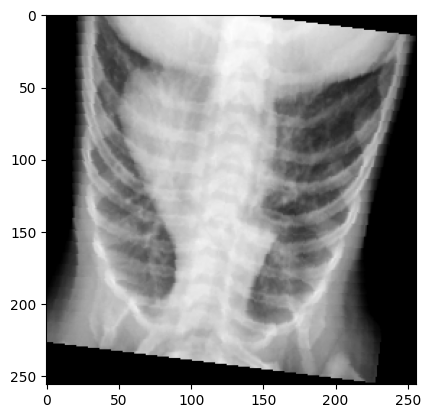

Label: 1


In [64]:
# Code Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterate-through-the-dataloader

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[21].squeeze() # Change the index (0 to 63) to display a different image in batch
label = train_labels[1] # [0] for Normal & [1] for Pneumonia

img = img.permute(1, 2, 0)  # Change the shape to (256, 256, 3)
plt.imshow(img)
plt.show()
print(f"Label: {label}")